In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data= pd.read_csv('tesla.csv')
data.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [3]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


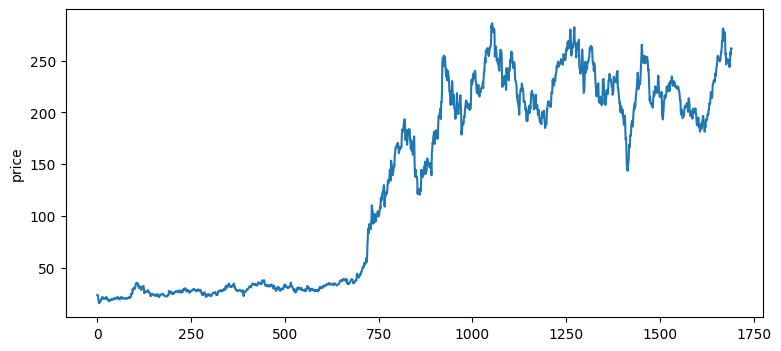

In [5]:
plt.figure(figsize=(9,4))
plt.plot(data['Close'])
plt.ylabel('price')
plt.show()

In [6]:

import numpy as np

data['Close'] = data['Close'].fillna(data['Close'].mean())
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
X = data[features].values
y = data['Target'].values

# Step 2: Standard Scaling
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1
X_scaled = (X - X_mean) / X_std

# Step 3: PCA
cov_matrix = np.cov(X_scaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
sorted_idx = np.argsort(eigenvalues)[::-1]
principal_components = eigenvectors[:, sorted_idx[:2]]
X_pca = np.dot(X_scaled, principal_components)

# Step 4: Train-test split
split = int(0.8 * len(X_pca))
X_train, X_test = X_pca[:split], X_pca[split:]
y_train, y_test = y[:split], y[split:]

# Step 5: Manual Linear SVR using Gradient Descent
class LinearSVR:
    def __init__(self, learning_rate=0.01, epochs=1000, C=1.0, epsilon=0.1):
        self.lr = learning_rate
        self.epochs = epochs
        self.C = C
        self.epsilon = epsilon

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0

        for epoch in range(self.epochs):
            for i in range(len(X)):
                x_i = X[i]
                y_i = y[i]
                y_pred = np.dot(self.w, x_i) + self.b
                error = y_pred - y_i

                if abs(error) > self.epsilon:
                    grad = self.C * np.sign(error)
                    self.w -= self.lr * grad * x_i
                    self.b -= self.lr * grad

    def predict(self, X):
        return np.dot(X, self.w) + self.b

# Step 6: Train and predict
svr = LinearSVR(learning_rate=0.001, epochs=500, C=1.0, epsilon=5.0)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

# Step 7: Evaluation
def evaluate_regression(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    return mse, mae, r2

mse, mae, r2 = evaluate_regression(y_test, y_pred)

print("Manual Linear SVM Regression with PCA:")
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


Manual Linear SVM Regression with PCA:
MSE: 28.79, MAE: 3.96, R²: 0.95


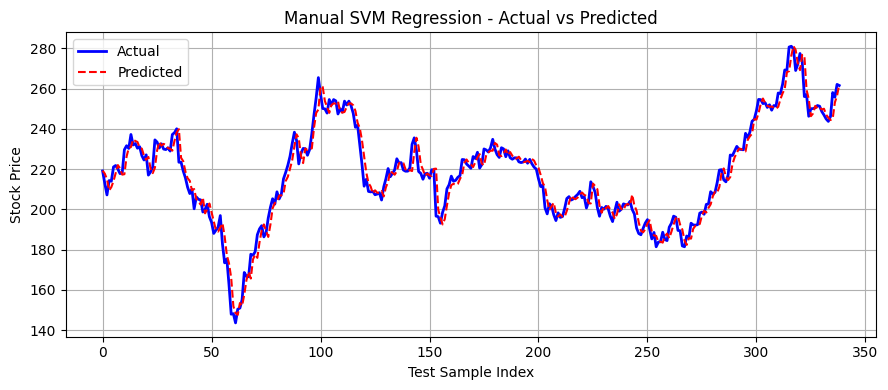

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', linewidth=2)
plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Price')
plt.title('Manual SVM Regression - Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()